In [1]:
from transformers import SegformerFeatureExtractor, SegformerForImageClassification,SegformerForSemanticSegmentation, SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# Extract the class label mapping from the configuration as a dictionary
url = "DSC09638.jpg"
image = Image.open(url)


feature_extractor_clothings = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
model_clothings = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")

feature_extractor_deep_clothing = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b5")
model_deep_clothing = SegformerForImageClassification.from_pretrained("nvidia/mit-b5")

processor_person = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model_person = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")


processor_prospect = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model_prospect = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

feature_extractor_prospect2 = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")
model_prospect2 = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-cityscapes-1024-1024")


# model predicts one of the 1000 ImageNet classes




c:\Users\19521\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\19521\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\19521\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [2]:

inputs_clothings = feature_extractor_clothings(images=image, return_tensors="pt")
inputs_deep_clothing = feature_extractor_deep_clothing(images=image, return_tensors="pt")
# inputs_prospect2 = feature_extractor_prospect2(images=image, return_tensors="pt")
inputs_persons = processor_person(images=image, return_tensors="pt")
inputs_prospect = processor_prospect(images=image, return_tensors="pt")

outputs_prospect = model_prospect(**inputs_prospect)
outputs_clothings = model_clothings(**inputs_clothings)
outputs_deep_clothing = model_deep_clothing(**inputs_clothings)
# outputs_prospect2 = model_prospect2(**inputs_prospect2)
outputs_person = model_person(**inputs_persons)


In [3]:
logits_clothings = outputs_clothings.logits
logits_deep_clothing = outputs_deep_clothing.logits
# logits_prospect2 = outputs_prospect2.logits
logits_prospect = outputs_prospect.logits.cpu()
# logits_prospect = outputs_prospect.logits
logits_person = outputs_person.logits.cpu()

upsampled_logits = nn.functional.interpolate(
    logits_person,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
    
)

pred_seg = upsampled_logits.argmax(dim=1)[0]
# output_prospect_tensor = outputs_prospect['pixel_values']
# output_prospect_image = Image.fromarray(output_prospect_tensor[0].numpy().astype('uint8'))
upsampled_logits_2 = nn.functional.interpolate(
    logits_prospect,
    size=image.size[::-1],
    mode="bilinear",
    align_corners=False,
    
)
pred_seg_prospect = upsampled_logits_2.argmax(dim=1)[0]

In [4]:

predicted_class_idx_clothings = logits_clothings.argmax(-1).item()
predicted_class_idx_deep_clothing = logits_deep_clothing.argmax(-1).item()
# predicted_class_idx_prospect2 = logits_prospect2.argmax(dim=-1)
# predicted_class_idx_prospect = logits_prospect.argmax(-1).item()


In [15]:
segmentation_map = pred_seg
segmentation_map_prospect = pred_seg_prospect
file_name = "tensor_data.txt"

# Open the text file in write mode and write the NumPy array to it
with open(file_name, "w") as text_file:
    for row in segmentation_map.numpy():
        formatted_row = " ".join(map(str, row))  # Convert each row to a string
        text_file.write(formatted_row + "\n")
segment_ids = torch.unique(segmentation_map)
segment_ids_prospect = torch.unique(segmentation_map_prospect)

# Map segment IDs to class labels

predicted_labels = [model_person.config.id2label.get(segment_id.item(), "Unknown") for segment_id in segment_ids]
predicted_labels_prospect = [model_prospect.config.id2label.get(segment_id.item(), "Unknown") for segment_id in segment_ids_prospect]


AttributeError: 'Tensor' object has no attribute 'decode'

In [6]:
predicted_labels_clothings= model_clothings.config.id2label[predicted_class_idx_clothings].split(', ')
predicted_labels_deep_clothing= model_deep_clothing.config.id2label[predicted_class_idx_deep_clothing].split(', ')
# predicted_labels_prospect2= model_prospect2.config.id2label[predicted_class_idx_prospect2]

model_clothings:     model_prospect:      model_person:        model deep clothing:
swimming trunks      wall                 Background           sunglasses          
bathing trunks       sky                  Hair                 dark glasses        
                     grass                Sunglasses           shades              
                     person               Upper-clothes                            
                     earth                Pants                                    
                     mountain             Left-shoe                                
                     plant                Right-shoe                               
                     water                Face                                     
                     sea                  Left-leg                                 
                     fence                Right-leg                                
                     rock                 Left-arm                          

Text(0.5, 1.0, 'Prospect')

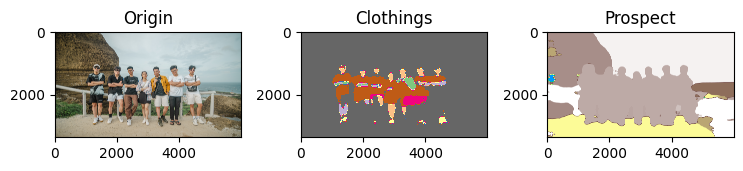

In [7]:

# print("Predicted class model_clothings:",predicted_labels_clothings )
# # print("Predicted class model_prospect2:",predicted_labels_prospect2 )
# print("Predicted class model_prospect:", "\n".join(predicted_labels_prospect))
# print("Predicted class model_person:", "\n".join(predicted_labels))
max_labels = max(len(predicted_labels_clothings), len(predicted_labels_prospect), len(predicted_labels),len(predicted_labels_deep_clothing))

# Print the labels in a tabular format
print("{:<20} {:<20} {:<20} {:<20}".format("model_clothings:", "model_prospect:", "model_person:","model deep clothing:"))

for i in range(max_labels):
    label_clothings = predicted_labels_clothings[i] if i < len(predicted_labels_clothings) else ""
    label_deep_clothing = predicted_labels_deep_clothing[i] if i < len(predicted_labels_deep_clothing) else ""
    label_prospect = predicted_labels_prospect[i] if i < len(predicted_labels_prospect) else ""
    label_person = predicted_labels[i] if i < len(predicted_labels) else ""
    
    print("{:<20} {:<20} {:<20} {:<20}".format(label_clothings, label_prospect, label_person,label_deep_clothing))
plt.rcParams["figure.figsize"] = [10.00, 5.50]
plt.rcParams["figure.autolayout"] = True
plt.subplot(1, 4, 1)
plt.imshow(image, cmap="Blues_r")
plt.title('Origin')
plt.subplot(1, 4, 2)
plt.imshow(pred_seg, cmap="Accent_r")
plt.title('Clothings')
plt.subplot(1, 4, 3)
plt.imshow(pred_seg_prospect, cmap="terrain_r")
plt.title('Prospect')
# plt.imshow( logits_prospect2.squeeze().cpu().numpy(), cmap='viridis')  # You can use a colormap of your choice
# plt.title('Prospect2')# Add a colorbar for reference
